<a href="https://colab.research.google.com/github/saniagonsalves/DM_assignment_part1/blob/main/B_2_gradient_boost_regression_techniques_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name- Sania Gonsalves

To building a regression model to estimate a home's sale price

In [ ]:
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew
from scipy.special import boxcox1p
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
import warnings
warnings.filterwarnings("ignore")

**Load the dataset**

In [ ]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
traindf = train.copy()
testdf = test.copy()

In [ ]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [ ]:
trainshape = ("Train Data:",train.shape[0],"obs, and", train.shape[1], "features" )
print("\033[95m {}\033[00m" .format(trainshape))
testshape = ("Test Data:",test.shape[0],"obs, and", test.shape[1], "features" )
print("\033[95m {}\033[00m" .format(testshape))

 ('Train Data:', 1460, 'obs, and', 81, 'features')
 ('Test Data:', 1459, 'obs, and', 80, 'features')


In [ ]:
# save id 
train_id = train["Id"]
test_id = test["Id"]

# drop id
train.drop("Id" , axis = 1 , inplace = True)
test.drop("Id" , axis = 1 , inplace = True)

In [ ]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0
BsmtFinSF2,1460.0,46.549315,161.319273,0.0,0.00,0.0,0.00,1474.0


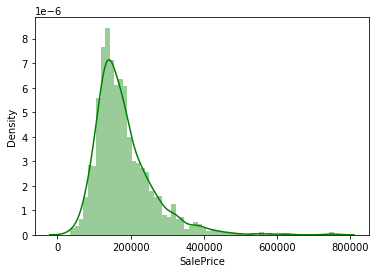

In [ ]:
# Focus Target Variable

sns.distplot(train["SalePrice"] , color = "g", bins = 60 , hist_kws={"alpha": 0.4});

The target variable SalePrice is not distributed normally.

This can reduce the performance of the ML regression models because some of them assume normal distribution.

Therfore we need to log transform.

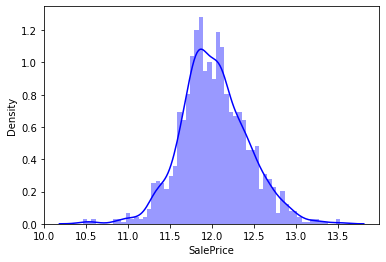

In [ ]:
sns.distplot(np.log1p(train["SalePrice"]) , color = "b", bins = 60 , hist_kws={"alpha": 0.4});

**create the best 8 correlation with heatmap.**

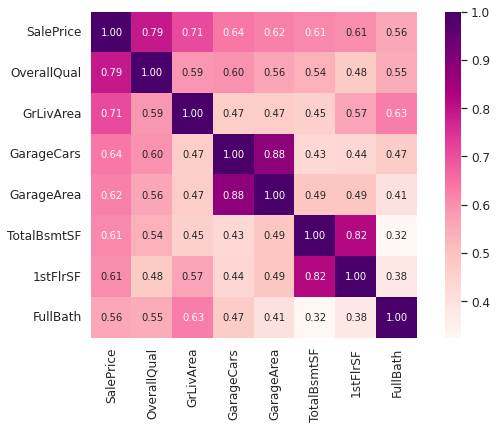

In [ ]:
corrmatrix = train.corr()
plt.figure(figsize = (10,6))
columnss = corrmatrix.nlargest(8, "SalePrice")["SalePrice"].index
cm = np.corrcoef(train[columnss].values.T)
sns.set(font_scale = 1.1)
hm = sns.heatmap(cm, cbar = True, annot = True, square = True, cmap = "RdPu" ,  fmt = ".2f", annot_kws = {"size": 10},
                 yticklabels = columnss.values, xticklabels = columnss.values)
plt.show()

The distribution of the variable with the 3 highest correlations.

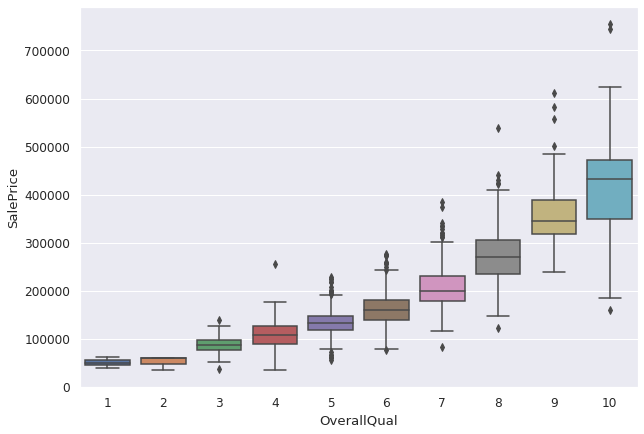

In [ ]:
f, ax = plt.subplots(figsize = (10, 7))
sns.boxplot(x = "OverallQual", y = "SalePrice", data = train);

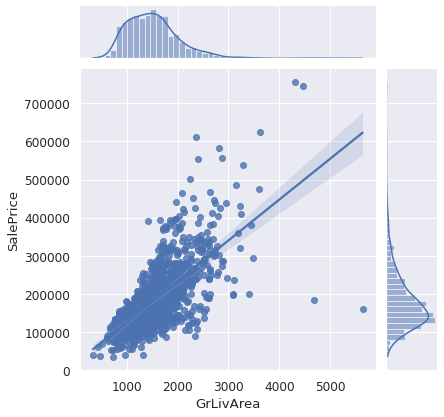

In [ ]:
sns.jointplot(x = train["GrLivArea"], y = train["SalePrice"], kind = "reg");

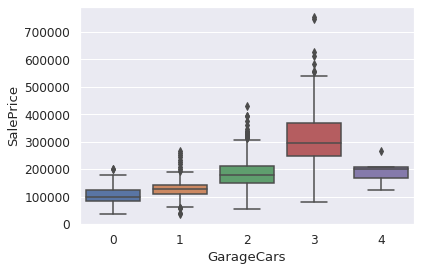

In [ ]:
sns.boxplot(x = train["GarageCars"], y = train["SalePrice"]);

**To remove outliers**

In [ ]:
train = train.drop(train[(train["GrLivArea"] > 4000) 
                         & (train["SalePrice"] < 200000)].index).reset_index(drop = True)
train = train.drop(train[(train["GarageCars"] > 3) 
                         & (train["SalePrice"] < 300000)].index).reset_index(drop = True)

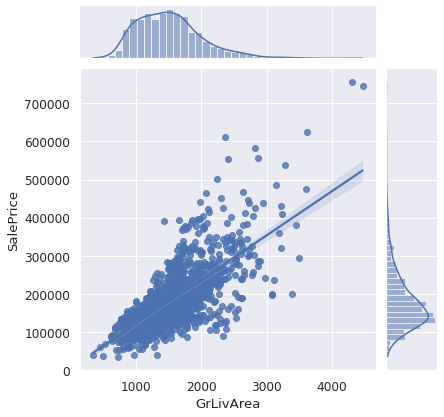

In [ ]:
sns.jointplot(x = train["GrLivArea"], y = train["SalePrice"], kind = "reg");

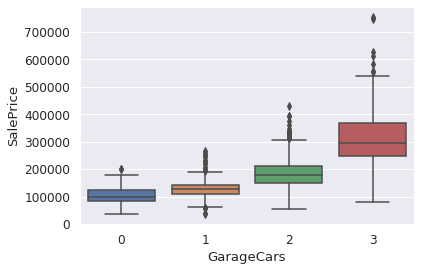

In [ ]:
sns.boxplot(x = train["GarageCars"], y = train["SalePrice"]);

Next step is to concanete train and test data for some cleaning operations.

In [ ]:
df = pd.concat((train, test)).reset_index(drop = True)
df.drop(["SalePrice"], axis = 1, inplace = True)
df.shape

(2912, 79)

In [ ]:
##Focus missing values

df.isna().sum().nlargest(35)

PoolQC          2903
MiscFeature     2807
Alley           2715
Fence           2342
FireplaceQu     1417
LotFrontage      485
GarageYrBlt      159
GarageFinish     159
GarageQual       159
GarageCond       159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
Utilities          2
BsmtFullBath       2
BsmtHalfBath       2
Functional         2
Exterior1st        1
Exterior2nd        1
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
KitchenQual        1
GarageCars         1
GarageArea         1
SaleType           1
MSSubClass         0
dtype: int64

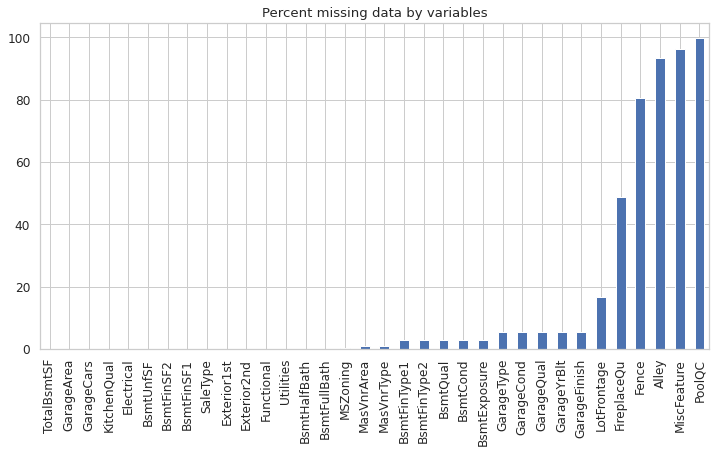

In [ ]:
sns.set_style("whitegrid")
f , ax = plt.subplots(figsize = (12, 6))
miss = round(df.isnull().mean()*100,2)
miss = miss[miss > 0]
miss.sort_values(inplace = True)
miss.plot.bar(color = "b")
ax.set(title="Percent missing data by variables");

Filling missing values

In [ ]:
some_miss_columns = ["PoolQC","MiscFeature","Alley","Fence","FireplaceQu","GarageType","GarageFinish","GarageQual","GarageCond",
                  "BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2","MasVnrType","MSSubClass"]

for i in some_miss_columns :
        df[i].fillna("None" , inplace = True)

In [ ]:
df["Functional"] = df["Functional"].fillna("Typ")

In [ ]:
some_miss_columns2 = ["MSZoning", "BsmtFullBath", "BsmtHalfBath", "Utilities","MSZoning",
                      "Electrical", "KitchenQual", "SaleType","Exterior1st", "Exterior2nd","MasVnrArea"]
for i in some_miss_columns2:
    df[i].fillna(df[i].mode()[0], inplace = True)

In [ ]:
some_miss_columns3 = ["GarageYrBlt", "GarageArea", "GarageCars","BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF"]
for i in some_miss_columns3 :
    df[i] = df[i].fillna(0)

In [ ]:
df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [ ]:
##We've filled out all the missing data.
df.isna().sum().nlargest(3)

MSSubClass     0
MSZoning       0
LotFrontage    0
dtype: int64

In [ ]:
## Transform for some variables
Nm = ["MSSubClass","MoSold","YrSold"]
for col in Nm:
    df[col] = df[col].astype(str)

Label Encoder

Convert this kind of categorical text data into model-understandable numerical data, we use the Label Encoder class.

In [ ]:
label = LabelEncoder()
encodecolumns = ("FireplaceQu","BsmtQual","BsmtCond","ExterQual","ExterCond","HeatingQC","GarageQual",
                "GarageCond","PoolQC","KitchenQual","BsmtFinType1","BsmtFinType2","Functional","Fence",
                "BsmtExposure","GarageFinish","LandSlope","LotShape","PavedDrive","Street","Alley",
                "CentralAir","MSSubClass","OverallCond","YrSold","MoSold")
for i in encodecolumns :
    label.fit(list(df[i].values))
    df[i] = label.transform(list(df[i].values))

Log Transform for SalePrice

Apply logarithmic transformation to our target variable.Because ML models work better with normal distribution.

In [ ]:
train["SalePrice"] = np.log1p(train["SalePrice"])
y = train.SalePrice.values
y[:5]

array([12.24769912, 12.10901644, 12.31717117, 11.84940484, 12.4292202 ])

Fix all of the skewed data to be more normal so that the models will be more accurate when making predictions

In [ ]:
numeric = df.dtypes[df.dtypes != "object"].index
skewed_var = df[numeric].apply(lambda x: skew(x.dropna())).sort_values(ascending = False)
skewness = pd.DataFrame({"Skewed Features" :skewed_var})
skewness.head()

,Skewed Features
MiscVal,21.920854
PoolArea,17.673354
LotArea,13.150188
LowQualFinSF,12.073977
3SsnPorch,11.362112


In [ ]:
skewness = skewness[abs(skewness) > 0.75]
skewed_var2 = skewness.index
for i in skewed_var2:
    df[i] = boxcox1p(df[i], 0.15)
    df[i] += 1

In [ ]:
df = pd.get_dummies(df)
df.head()

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,...,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,3.885846,6.831328,20.212182,1.730463,1.730463,2.540963,1.0,3.440268,2.820334,15.187527,15.187527,9.059126,2.194318,2.820334,2.194318,2.820334,2.540963,2.194318,12.170327,3.259674,1.0,8.483296,12.692623,1.000000,1.730463,12.692623,12.686189,1.0,14.698888,1.730463,1.000000,2.194318,1.730463,2.540963,1.730463,2.194318,3.602594,3.259674,1.000000,2.540963,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,3.055642,7.221214,20.712205,1.730463,1.730463,2.540963,1.0,3.259674,3.440268,15.145138,15.145138,1.000000,2.540963,2.820334,2.194318,2.820334,1.730463,1.000000,13.062832,3.259674,1.0,9.897844,13.792276,1.000000,1.730463,13.792276,1.000000,1.0,13.792276,1.000000,1.730463,2.194318,1.000000,2.540963,1.730463,2.540963,3.259674,3.259674,1.730463,3.055642,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,3.885846,6.914940,21.347241,1.730463,1.730463,1.000000,1.0,3.440268,2.820334,15.184404,15.185966,8.646538,2.194318,2.820334,2.194318,2.820334,2.194318,2.194318,11.200343,3.259674,1.0,10.917060,12.892039,1.000000,1.730463,12.892039,12.724598,1.0,14.832085,1.730463,1.000000,2.194318,1.730463,2.540963,1.730463,2.194318,3.259674,3.259674,1.730463,3.055642,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,4.011340,6.684507,20.691553,1.730463,1.730463,1.000000,1.0,3.440268,2.820334,15.047529,15.135652,1.000000,2.540963,2.820334,2.820334,1.730463,2.540963,1.000000,9.274266,3.259674,1.0,11.468500,12.354094,2.194318,1.730463,13.013683,12.354094,1.0,14.711364,1.730463,1.000000,1.730463,1.000000,2.540963,1.730463,2.194318,3.440268,3.259674,1.730463,2.194318,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,3.885846,7.314735,22.325160,1.730463,1.730463,1.000000,1.0,3.602594,2.820334,15.182841,15.182841,10.391827,2.194318,2.820334,2.194318,2.820334,1.000000,2.194318,11.971129,3.259674,1.0,11.221051,13.510588,1.000000,1.730463,13.510588,13.271365,1.0,15.480029,1.730463,1.000000,2.194318,1.730463,2.820334,1.730463,2.194318,3.750250,3.259674,1.730463,3.055642,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [ ]:
X_train = df[:train.shape[0]]
X_test = df[train.shape[0]:]

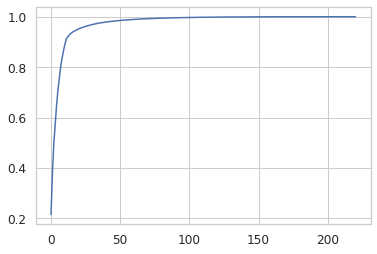

In [ ]:
dff = df.copy()
##df_standardize = StandardScaler().fit_transform(dff)
##I didn't standardize it again because the data is already close to the standard.
pca = PCA()
pca_fit = pca.fit_transform(dff)
pca = PCA().fit(dff)
plt.plot(np.cumsum(pca.explained_variance_ratio_));

In [ ]:
pca = PCA(n_components = 30)
pca_fit = pca.fit_transform(dff)
pca_df = pd.DataFrame(data = pca_fit)
pca_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,1.310874,-7.644388,-3.190557,-6.130242,-1.231003,1.802676,0.149904,1.802519,-0.081996,-1.064012,1.049449,0.543263,0.244838,-0.246355,0.017458,-0.299869,-1.111254,0.290707,-0.625801,-0.523687,0.020059,0.704840,-0.559024,0.053761,0.324437,-0.280707,-0.265869,0.087586,0.122488,-0.126234
1,-6.792759,0.934007,-1.220512,5.201498,1.143536,-3.922942,-3.233540,0.318292,-1.110764,-0.084848,-0.231385,0.817976,-0.088413,-0.024101,0.116759,-0.187904,0.207383,-0.460834,-0.250640,0.011708,0.254236,0.461961,0.078940,-0.357036,0.558216,1.405006,-0.333637,0.219425,-0.754467,0.853694
2,2.258800,-7.309320,-1.561536,-5.963476,-1.504997,0.673385,-0.047281,0.567739,-0.445352,-0.352704,1.015859,1.561197,-0.387181,-0.500928,0.429981,-0.437431,-1.341218,-0.608019,0.683963,-0.122423,-0.044516,0.254259,0.102799,0.153587,0.585364,-0.606748,-0.258185,-0.287160,0.166597,-0.192120
3,5.713698,-1.996913,-4.386689,-2.343667,-4.081766,-3.358525,-0.259982,-2.570543,6.024252,-1.719936,-1.049914,-0.367485,-0.826502,-0.414420,0.284292,-0.018529,0.251988,0.714295,1.000392,-0.604666,0.131088,-1.499563,0.637223,-0.344207,0.877413,0.743953,1.042825,0.288711,-0.383856,-0.369609
4,0.639671,-12.038284,0.643347,-0.953167,2.368347,0.493921,-0.421904,0.242407,0.724364,-0.126743,0.060159,1.565073,-0.665240,-0.259254,0.085398,-0.231630,-0.759135,0.775718,0.294823,-0.364313,-0.267248,-0.098037,0.311436,0.415777,0.935320,-0.249881,-0.166891,0.108523,0.232505,0.396134


Now predict models Firstly start Cross-validation with k-folds

In [ ]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle = True, random_state = 42).get_n_splits(X_train.values)
    rmse = np.sqrt(-cross_val_score(model, X_train.values, y, scoring = "neg_mean_squared_error", cv = kf))
    return(rmse)

In [ ]:
model_xgb = xgb.XGBRegressor(colsample_bytree = 0.2, gamma = 0.0 ,
                             learning_rate = 0.05, max_depth = 6, 
                             min_child_weight = 1.5, n_estimators = 7200,
                             reg_alpha = 0.9, reg_lambda = 0.6,
                             subsample = 0.2,seed = 42,
                             random_state = 7)

model_gbm = GradientBoostingRegressor(n_estimators = 3000, learning_rate = 0.05,
                                   max_depth = 4, max_features = "sqrt",
                                   min_samples_leaf = 15, min_samples_split = 10, 
                                   loss = "huber", random_state = 5)

In [ ]:
score = rmsle_cv(model_xgb)
print("XGBoost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_gbm)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[19:56:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:58:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost score: 0.1193 (0.0049)

Gradient Boosting score: 0.1155 (0.0067)



In [ ]:
## we need this func
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

GBM (Gradient Boosting Machines)

In [ ]:
model_xgb.fit(X_train, y)
xgb_train_pred = model_xgb.predict(X_train)
xgb_pred = np.expm1(model_xgb.predict(X_test))
print(rmsle(y, xgb_train_pred))

[20:03:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.04271629202457775


In [ ]:
xgb_pred[:5]

array([127030.77, 162863.1 , 187234.12, 195402.38, 187380.44],
      dtype=float32)

In [ ]:
model_gbm.fit(X_train, y)
gbm_train_pred = model_gbm.predict(X_train)
gbm_pred = np.expm1(model_gbm.predict(X_test.values))
print(rmsle(y, gbm_train_pred))

0.05041437359684839


In [ ]:
gbm_pred[:5]

array([120735.81992324, 156981.67681747, 194467.06024408, 196102.90381639,
       189486.60416949])

In [ ]:
best = (0.5 * xgb_pred ) + (0.5 * gbm_pred)

In [ ]:
submission = pd.DataFrame({"Id": test_id, "SalePrice": best})
submission.head(5)

,Id,SalePrice
0,1461,123883.296680
1,1462,159922.385284
2,1463,190850.592622
3,1464,195752.639408
4,1465,188433.520835


In [ ]:
submission.to_csv("submission.csv", index = False)

save the data in csv file